In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tqdm import trange, tqdm
from kornia.filters.gaussian import gaussian_blur2d

from trainer import Trainer, generate_data_iter
import utils
import cam
import attack

model_mode, dataset = 'mobilenetv3_large_100', 'Imagenette'
target_layer = 'layer4' if model_mode == 'resnet' else 'blocks'
fig_num = 200
metrics = {}

In [2]:
utils.set_random_seed(0)
trainer = Trainer(
    model_mode = model_mode,
    dataset = dataset,
    bs = 128,
    lr = 0.01,
    seed = 0,
    cuda = 0,
    use_lr_sche = True,
    use_wandb = False,
)
trainer.load()
# top1_acc, top5_acc = trainer.evaluate_model()
# print(f'Top 1 Acc: {top1_acc * 100:4.2f}%\tTop 5 Acc: {top5_acc * 100:4.2f}%')

test_iter = generate_data_iter(dataset, batch_size = fig_num, mode = 'test')
imgs, labels = next(iter(test_iter))

idx = 4

## Grad-CAM

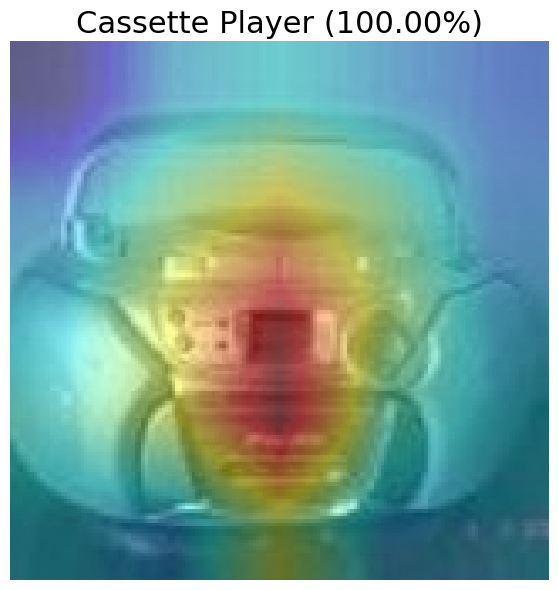

In [3]:
mycam = cam.GradCAM(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])

In [4]:
mycam.calc_avg_inc_drop(imgs)

(tensor(0.1650, device='cuda:0'), tensor(0.0237, device='cuda:0'))

0.46074758814227906


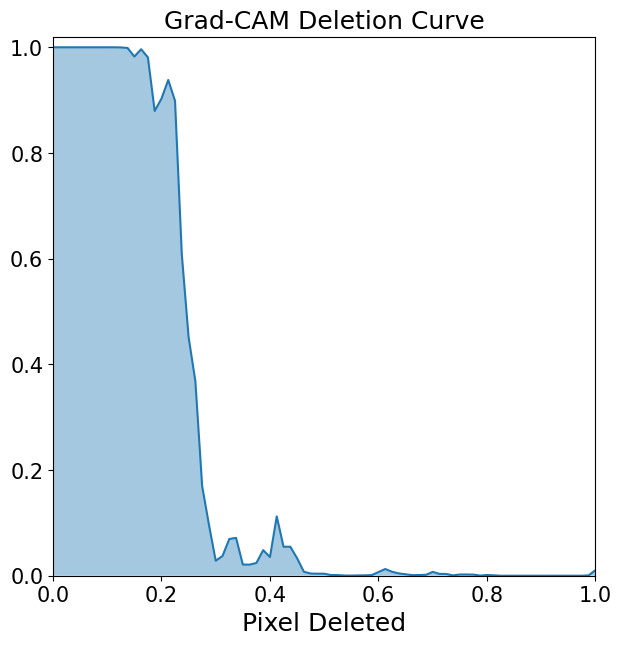

In [5]:
dele, dele_scores = mycam.calc_causal_metric(imgs, ins = False)
print(dele)
cam.plot_casual_metrics(dele_scores[:, 0], 'Grad-CAM', ins = False)

## Grad-CAM++

In [ ]:
mycam = cam.GradCAMpp(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])

In [ ]:
mycam.evaluate(imgs)

In [ ]:
blur = lambda x: gaussian_blur2d(x, kernel_size=(51, 51), sigma=(50., 50.))
insertion = utils.CausalMetric(trainer.model, 'ins', 160, substrate_fn=blur)

In [ ]:
saliency_maps, pred, prob = mycam.generate_saliency_map(imgs)
idx = 0
scores = insertion.evaluate(imgs[idx].unsqueeze(0), saliency_maps[idx], 160 * 160, pred[idx], verbose = 1)

In [ ]:
from sklearn.metrics import auc
x = np.linspace(0, 1, len(scores))
auc(x, scores)

## Smooth Grad-CAM++

In [ ]:
mycam = cam.SmoothGradCAMpp(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])

## LayerCAM

In [ ]:
mycam = cam.LayerCAM(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])

## XGrad-CAM

In [ ]:
mycam = cam.XGradCAM(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])

## Score-CAM

In [ ]:
mycam = cam.ScoreCAM(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])

## SS-CAM

In [ ]:
mycam = cam.SSCAM(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])

## IS-CAM

In [ ]:
mycam = cam.ISCAM(trainer.model, dataset, target_layer)
cam_nps, preds, probs = mycam(imgs)
cam.plot_cam_img(cam_nps[idx], dataset, preds[idx], probs[idx])